# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

HR-агентства хочет ответить на следующие вопросы, касающиеся заработной платы:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные о зарплатах в сфере Data Science за 2020–2022 годы.

Данные содержат следующие столбцы:
*   *work_year* — Год, в котором была выплачена зарплата;
*   *experience_level* — Опыт работы на этой должности в течение года со следующими возможными значениями: EN (Entry-level/Junio), MI (Mid-level/Intermediate), SE (Senior-level/Expert), EX (Executive-level/Director);
*   *employment_type* — Тип трудоустройства для этой роли: PT (неполный рабочий день), FT (полный рабочий день), CT (контракт), FL (фриланс);
*   *job_title* — Роль, в которой соискатель работал в течение года;
*   *salary* — Общая выплаченная валовая сумма заработной платы;
*   *salary_currency* — Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217;
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com);
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения:0 - (удалённой работы нет (менее 20 %)), 50 - (частично удалённая работа), 100 - (полностью удалённая работа (более 80 %));
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   *company_size* — Среднее количество людей, работавших в компании в течение года: S - (менее 50 сотрудников (небольшая компания)), M - (от 50 до 250 сотрудников (средняя компания)), L - (более 250 сотрудников (крупная компания)).

Оригинальный датасет: ["Data Science Job Salaries” (kaggle.com)"]

## Загрузка данных

In [1]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [3]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


<Axes: >

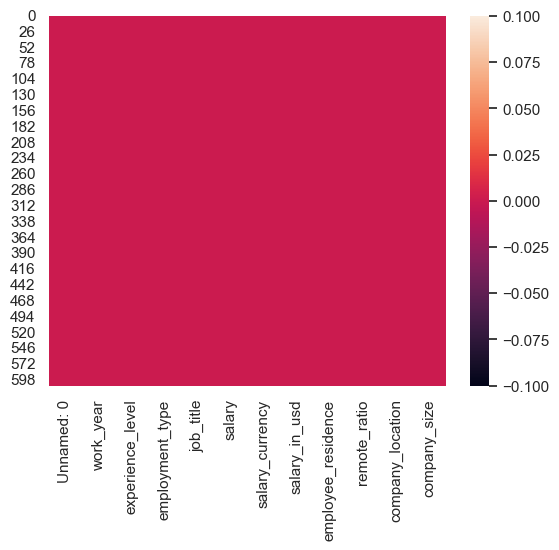

In [6]:
sns.heatmap(data.isnull()) # # убеждаемся, что датасет без пропусков

В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов, а также удалим признак salary, аналогичный более универсальному и поддающемуся статестической оработке признаку salary_in_usd, а также удаление признака salary_currency, поскольку мы будем оперировать зарплатой уже переведенной в доллары США. Так же будет удален признак Unnamed не имеющий значения для статистического анализа.

In [7]:
# Проверяем наличие дубликатов:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
# Удаляем столбцы "salary" и "salary_currency" из DataFrame
data = data.drop(columns=['salary', 'salary_currency'])
data.info()

Количество дубликатов: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary_in_usd       607 non-null    int64 
 6   employee_residence  607 non-null    object
 7   remote_ratio        607 non-null    int64 
 8   company_location    607 non-null    object
 9   company_size        607 non-null    object
dtypes: int64(4), object(6)
memory usage: 47.5+ KB


### Проведём корреляционный анализ датасета и используем для этого тепловую карту корреляций признаков

<Axes: >

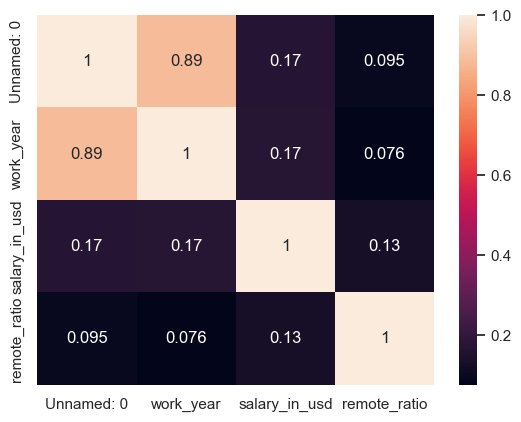

In [8]:
# отсеиваем числовые признаки и включаем отображение коэффициентов
sns.heatmap(data.corr(numeric_only=True), annot=True)

В датасете нет неинформативных признаков которые из за мультиколлениарности с другими признаками подлежали бы исключению  

### Классификация признаков датасета на числовые и категориальные

Категориальные признаки:
*   *work_year* — Год, в котором была выплачена зарплата;
*   *experience_level* — Опыт работы на этой должности в течение года со следующими возможными значениями: EN (Entry-level/Junio), MI (Mid-level/Intermediate), SE (Senior-level/Expert), EX (Executive-level/Director);
*   *employment_type* — Тип трудоустройства для этой роли: PT (неполный рабочий день), FT (полный рабочий день), CT (контракт), FL (фриланс);
*   *job_title* — Роль, в которой соискатель работал в течение года;
*   *employee_residence* — Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166;
*   *remote_ratio* — Общий объём работы, выполняемой удалённо. Возможные значения:0 - (удалённой работы нет (менее 20 %)), 50 - (частично удалённая работа), 100 - (полностью удалённая работа (более 80 %));
*   *company_location* — Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   *company_size* — Среднее количество людей, работавших в компании в течение года: S - (менее 50 сотрудников (небольшая компания)), M - (от 50 до 250 сотрудников (средняя компания)), L - (более 250 сотрудников (крупная компания)).

Численные признаки:
*   *salary_in_usd* — Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com)

### Определение основных статистических характеристик для каждого из признаков

Для определения основных статестических характеристик прзнаков датасета постоим отчет с использованием библиотеки sweetviz

In [9]:
import sweetviz as sv
report = sv.analyze(data)
report.show_html()

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Отчет по основным статистическим характеристикам признаков датасета получен

## Разведовательный анализ данных

### Визуальный анализ данных

### Распределение оплаты труда по всем соискателям по профессии Data Scientist за 2020-2022 годы

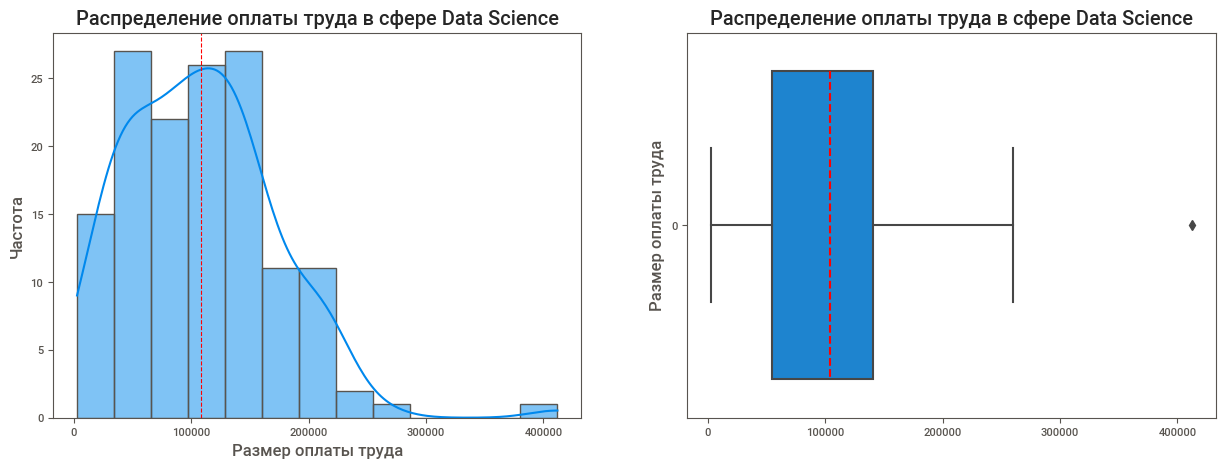

In [10]:
filtered_data = data[data['job_title'] == 'Data Scientist']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(filtered_data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Размер оплаты труда', ylabel='Частота')
axes[0].set_title('Распределение оплаты труда в сфере Data Science')
axes[0].axvline(filtered_data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(filtered_data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер оплаты труда')
axes[1].set_title('Распределение оплаты труда в сфере Data Science')

plt.show()

In [11]:
data_agg = filtered_data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер страховых выплат']
data_agg

,Размер страховых выплат
count,143.00
mean,108187.83
std,64112.84
min,2859.00
25%,54724.00
50%,103691.00
75%,140850.00
max,412000.00


Распределение оплаты труда отлично от нормального, имеются выбросы.

### Оплата труда в зависимости от года, в котором была выплачена зарплата

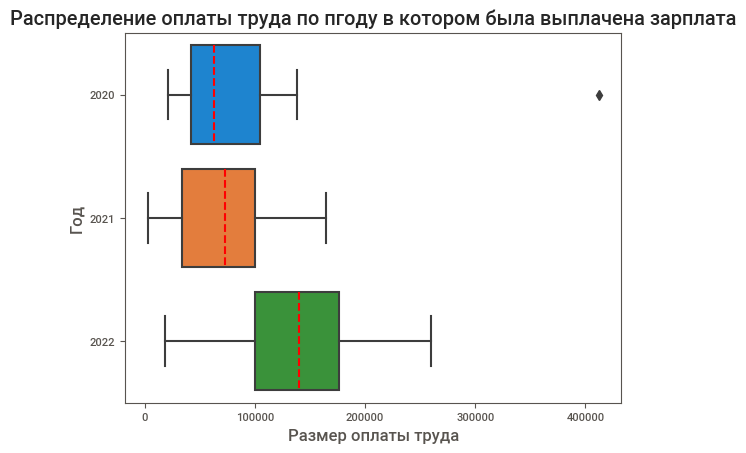

In [12]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Год')
plt.title('Распределение оплаты труда по пгоду в котором была выплачена зарплата')
plt.show()

In [13]:
data_agg = filtered_data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Распределение оплаты труда по пгоду в котором была выплачена зарплата')
data_agg

Распределение оплаты труда по пгоду в котором была выплачена зарплата


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.0,62726.0,105000.0,412000.0
2021,45.0,70671.73,45422.97,2859.0,33808.0,73000.0,100000.0,165000.0
2022,77.0,136172.09,54563.08,18442.0,100000.0,140000.0,176000.0,260000.0


Распределение оплаты труда по пгоду в котором была выплачена зарплата имеет тенденцию к уверенному увеличению средних и медианных значений за период с 2020 по 2022 гг., в тоже время отмечается уменьшение количества выбросов и уменьшение максимальных значений, что может свидетельствовать как о росте спроса на данные виды специальностей в ИТ, так и о стадартизации квалификационных требований и компетенций самих соискателей, что выражено в уменьшении разници между минимальными и максимальными величинами оплаты труда.Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Оплата труда в зависимости от опыта работы соискателя

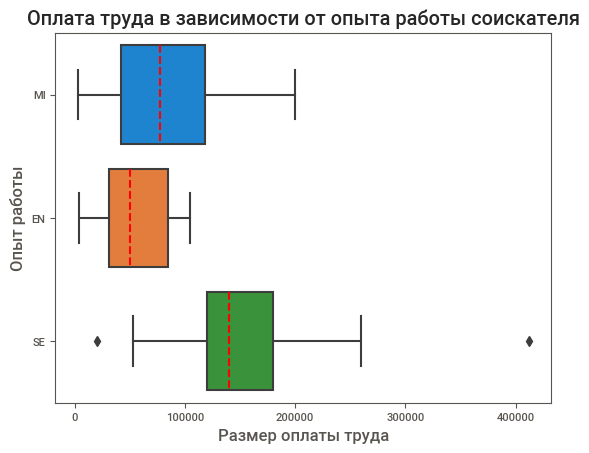

In [14]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Опыт работы')
plt.title('Оплата труда в зависимости от опыта работы соискателя')
plt.show()

In [15]:
data_agg = filtered_data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Оплата труда в зависимости от опыта работы соискателя')
data_agg

Оплата труда в зависимости от опыта работы соискателя


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,22.0,55330.91,31237.82,4000.0,31474.0,50483.5,85027.25,105000.0
MI,60.0,82039.13,46869.58,2859.0,41768.0,77479.0,118264.75,200000.0
SE,61.0,152971.02,58985.40,20171.0,120000.0,140400.0,180000.00,412000.0


Среднее значение оплаты труда увеличивается с опытом работы соискателя. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Зависимость оплаты труда от типа трудоустройства

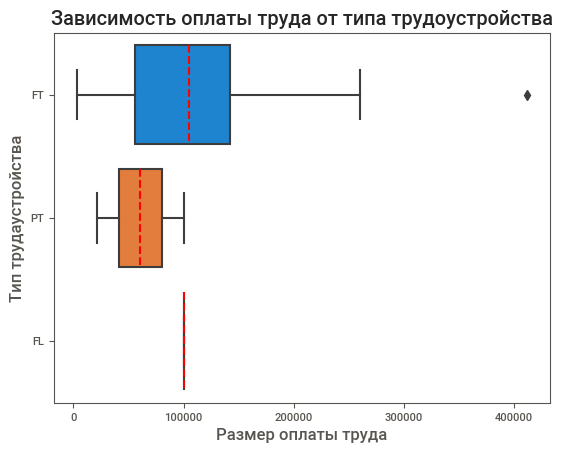

In [16]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Тип трудаустройства')
plt.title('Зависимость оплаты труда от типа трудоустройства')
plt.show()

In [17]:
data_agg = filtered_data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Зависимость оплаты труда от типа трудоустройства')
data_agg

Зависимость оплаты труда от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
FL,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
FT,140.0,108922.79,64372.43,2859.0,55490.00,104796.0,141975.00,412000.0
PT,2.0,60834.50,55388.38,21669.0,41251.75,60834.5,80417.25,100000.0


Распределения страховых выплат различны для разных типов трудоустройства. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

### Зависимость оплаты труда от страны проживания в течении рабочего года

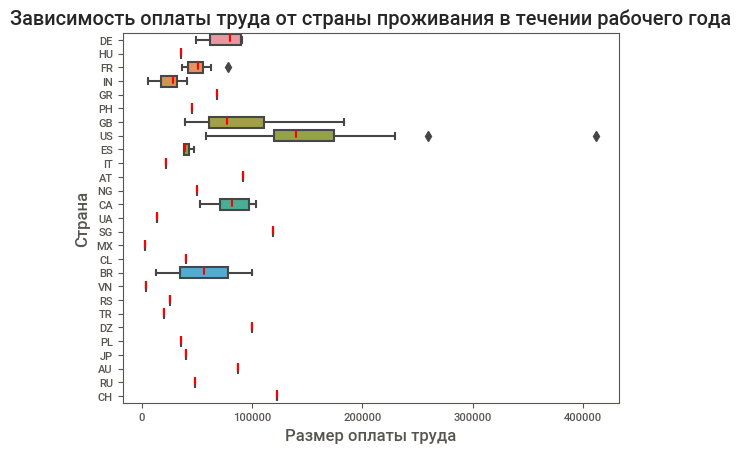

In [34]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Страна')
plt.title('Зависимость оплаты труда от страны проживания в течении рабочего года')
plt.show()

In [19]:
data_agg = filtered_data.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Зависимость оплаты труда от страны проживания в течении рабочего года')
data_agg

Зависимость оплаты труда от страны проживания в течении рабочего года


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AT,1.0,91237.00,NaN,91237.0,91237.00,91237.0,91237.00,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.00,86703.0,86703.00,86703.0
BR,2.0,56450.50,61588.29,12901.0,34675.75,56450.5,78225.25,100000.0
CA,6.0,81489.17,19500.74,52396.0,70945.50,81756.0,96934.50,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.00,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.00,40038.0,40038.00,40038.0
DE,7.0,74773.71,16834.87,49268.0,62096.50,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.00,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.50,38776.0,42792.50,46809.0


Среднее значение оплаты труда значительно отличается по разным странам проживания соискателей. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

### Зависимость оплаты труда от доли работы, выполняемой удаленно

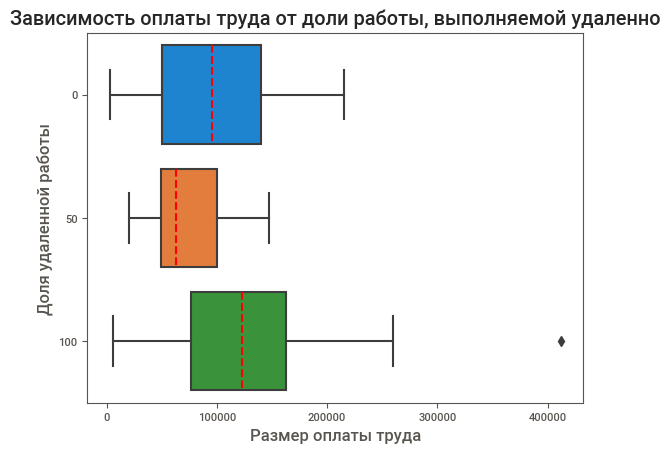

In [33]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Доля удаленной работы')
plt.title('Зависимость оплаты труда от доли работы, выполняемой удаленно')
plt.show()

In [24]:
data_agg = filtered_data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Зависимость оплаты труда от доли работы, выполняемой удаленно')
data_agg

Зависимость оплаты труда от доли работы, выполняемой удаленно


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,39.0,99520.74,58259.42,2859.0,50294.5,95550.0,140400.0,215300.0
50,25.0,74504.08,35602.82,20171.0,49646.0,62726.0,100000.0,147000.0
100,79.0,123125.94,69370.99,5679.0,76366.0,123000.0,162500.0,412000.0


Среднее значение оплаты труда значительно отличается в зависимости от доли работы, выполняемой удаленно. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

### Зависимость заработной платы от страны где размещен главный офис компании

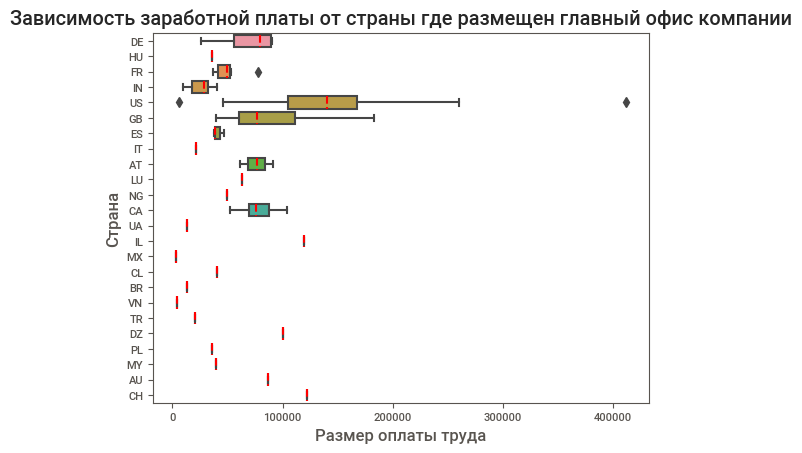

In [32]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Страна')
plt.title('Зависимость заработной платы от страны где размещен главный офис компании')
plt.show()

In [28]:
data_agg = filtered_data.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Зависимость заработной платы от страны где размещен главный офис компании')
data_agg

Зависимость заработной платы от страны где размещен главный офис компании


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AT,2.0,76352.00,21050.57,61467.0,68909.5,76352.0,83794.50,91237.0
AU,1.0,86703.00,NaN,86703.0,86703.0,86703.0,86703.00,86703.0
BR,1.0,12901.00,NaN,12901.0,12901.0,12901.0,12901.00,12901.0
CA,5.0,77787.00,19301.65,52396.0,69336.0,75774.0,87738.00,103691.0
CH,1.0,122346.00,NaN,122346.0,122346.0,122346.0,122346.00,122346.0
CL,1.0,40038.00,NaN,40038.0,40038.0,40038.0,40038.00,40038.0
DE,7.0,69640.14,25045.56,25532.0,55997.0,79833.0,89694.00,90734.0
DZ,1.0,100000.00,NaN,100000.0,100000.0,100000.0,100000.00,100000.0
ES,3.0,41136.67,4935.34,37825.0,38300.5,38776.0,42792.50,46809.0


Среднее значение оплаты труда значительно отличается по разным странам размещения головного офиса компании. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

### Зависимость размера заработной платы от размеров компании

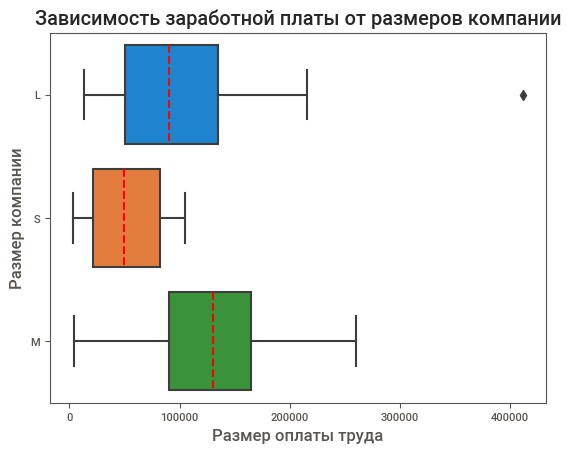

In [35]:
ax = sns.boxplot(filtered_data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер оплаты труда', ylabel='Размер компании')
plt.title('Зависимость заработной платы от размеров компании')
plt.show()

In [36]:
data_agg = filtered_data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Зависимость заработной платы от размера компании')
data_agg

Зависимость заработной платы от размера компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,45.0,103313.36,71815.18,13400.0,50000.0,90734.0,135000.0,412000.0
M,77.0,126380.75,56389.53,4000.0,90000.0,130000.0,165000.0,260000.0
S,21.0,51925.76,33216.29,2859.0,21669.0,49268.0,82500.0,105000.0


Среднее значение оплаты труда значительно отличается пв зависимости от компании. Чтобы определить, являются ли эти различия статистически значимыми, необходимы статистические тесты.

### Соотношение курящих среди мужчин и женщин

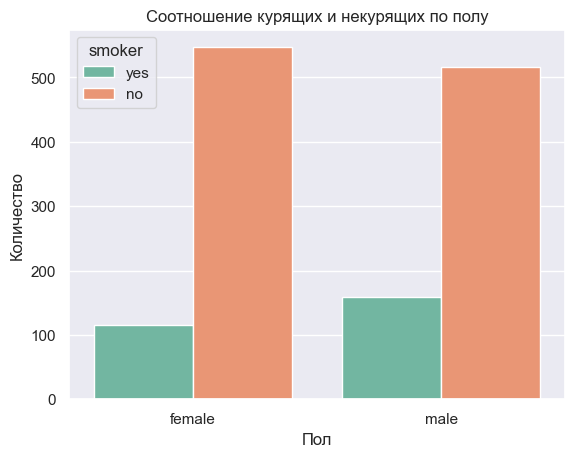

In [ ]:
ax = sns.countplot(data=data, x=data['sex'], hue='smoker')
ax.set(xlabel='Пол', ylabel='Количество')
plt.title('Соотношение курящих и некурящих по полу')
plt.show()

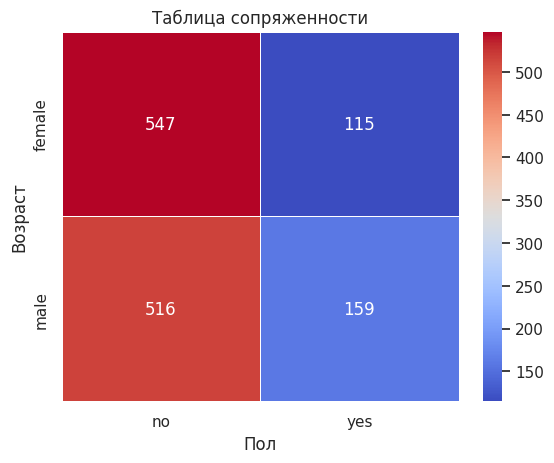

In [ ]:
cross_tab = pd.crosstab(index=data['sex'], columns=data['smoker'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Пол', ylabel='Возраст')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, среди курящих мужчин больше, чем женщин. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [ ]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически меньше либо равен размеру страховых выплат клиентов-женщин ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически больше, чем размер страховых выплат клиентов-женщин ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [ ]:
# значения страховых выплат
charges_male = data.loc[data['sex']=='male', 'charges']
charges_female = data.loc[data['sex']=='female', 'charges']

# проводим тест Шапиро-Уилка
print('Для мужчин:')
result = stats.shapiro(charges_male)
decision_normality(result[1])

print('Для женщин:')
result = stats.shapiro(charges_female)
decision_normality(result[1])

Для мужчин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для женщин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
# проводим тест
_, p = stats.mannwhitneyu(charges_male, charges_female, alternative='greater')
decision_hypothesis(p)

p-value = 0.694
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин.

### Размер страховых выплат для некурящих клиентов меньше, чем для курящих?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически больше либо равен размеру страховых выплат для курящих клиентов ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически меньше, чем размер страховых выплат для курящих клиентов ($μ_2$).
$$ H_1 : μ_1 < μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
charges_no_smoker = data.loc[data['smoker']=='no', 'charges']
charges_smoker = data.loc[data['smoker']=='yes', 'charges']

# проводим тест Шапиро-Уилка
print('Для некурящих клиентов:')
result = stats.shapiro(charges_no_smoker)
decision_normality(result[1])

print('Для курящих клиентов:')
result = stats.shapiro(charges_smoker)
decision_normality(result[1])

Для некурящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для курящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [ ]:
# проводим тест
_, p = stats.mannwhitneyu(charges_no_smoker, charges_smoker, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер страховых выплат для некурящих клиентов меньше, чем для курящих.

### Влияет ли регион проживания на размер выплат?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер страховых выплат не отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер страховых выплат отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
charges_northeast = data.loc[data['region']=='northeast', 'charges']
charges_southeast = data.loc[data['region']=='southeast', 'charges']
charges_northwest = data.loc[data['region']=='northwest', 'charges']
charges_southwest = data.loc[data['region']=='southwest', 'charges']

# проводим тест Шапиро-Уилка
print('Для северо-востока:')
result = stats.shapiro(charges_northeast)
decision_normality(result[1])

print('Для юго-востока:')
result = stats.shapiro(charges_southeast)
decision_normality(result[1])

print('Для северо-запада:')
result = stats.shapiro(charges_northwest)
decision_normality(result[1])

print('Для юго-запада:')
result = stats.shapiro(charges_southwest)
decision_normality(result[1])


Для северо-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для северо-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Регион проживания в США»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [ ]:
# проводим тест
_, p = stats.kruskal(charges_northeast, charges_southeast, charges_southwest, charges_northwest)
decision_hypothesis(p)

p-value = 0.202
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что есть разница в размере страховых выплат в разных регионах.

### Есть ли взаимосвязь между курением и полом?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, курит человек или нет, и его полом нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, курит человек или нет, и его полом есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [ ]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['sex'], data['smoker'])

cross_table

smoker,no,yes
sex,,
female,547,115
male,516,159


In [ ]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между полом и курением.

## Итоговые результаты исследования

*   Нет оснований утверждать, что есть разница в размере страховых выплат для клиентов-мужчин и клиентов-женщин.
*   Размер страховых выплат для некурящих клиентов меньше, чем для курящих.
*   Нет оснований утверждать, что есть разница в размере страховых выплат для разных регионов.
*   Существует взаимосвязь между полом и курением.